# MIKH Model: Creep Response

## Learning Objectives

1. Fit the **MIKH** model to creep data (constant stress, measure strain/shear rate)
2. Understand **delayed yielding** and **viscosity bifurcation** in thixotropic materials
3. Analyze the interplay between applied stress and yield stress evolution
4. Observe creep behavior above and below the yield stress
5. Apply Bayesian inference to quantify uncertainty in creep parameters

## Prerequisites

- NB01: MIKH Flow Curve (basic parameter understanding)

## Runtime

- Fast demo: ~3-4 minutes
- Full run: ~12-15 minutes

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import os
import sys
import time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.ikh import MIKH

# Add examples/utils to path for tutorial utilities
sys.path.insert(0, os.path.join("..", "utils"))
from ikh_tutorial_utils import (
    load_ml_ikh_creep,
    save_ikh_results,
    print_convergence_summary,
    print_parameter_comparison,
    compute_fit_quality,
    get_mikh_param_names,
)

# Shared plotting utilities
sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    plot_nlsq_fit,
    display_arviz_diagnostics,
    plot_posterior_predictive,
)

jax, jnp = safe_import_jax()
verify_float64()

# Suppress equinox DeprecationWarnings for jax.core.mapped_aval/unmapped_aval
# (third-party equinox internals, cannot fix at source — harmless with JAX 0.8.x)
warnings.filterwarnings(
    "ignore",
    message=r"jax\.core\.(mapped|unmapped)_aval",
    category=DeprecationWarning,
    module=r"equinox\..*",
)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")
# Startup cleanup: force garbage collection to reclaim memory from previous notebooks
import gc
gc.collect()


JAX version: 0.8.3
Devices: [CpuDevice(id=0)]


81

## 2. Theory: Creep in Thixotropic Materials

Creep tests apply a constant stress $\sigma_{app}$ and measure the resulting strain $\gamma(t)$ or shear rate $\dot{\gamma}(t)$.

### Creep Regimes in MIKH

**1. Below yield stress** ($\sigma_{app} < \sigma_y$):
- Initial elastic deformation: $\gamma_e = \sigma_{app}/G$
- Bounded creep (Andrade-like): $\gamma(t) \sim t^{1/3}$
- Structure rebuilds, no steady flow

**2. Above yield stress** ($\sigma_{app} > \sigma_y$):
- Initial elastic + plastic deformation
- Structure breakdown → shear rate increases
- Steady-state flow: $\dot{\gamma}_{ss} = (\sigma_{app} - \sigma_{y,ss})/\eta_{eff}$

### Delayed Yielding

For stresses near the yield stress, the material can exhibit **delayed yielding**:
- Initially creeps slowly
- Structure gradually breaks down
- Yield stress decreases until $\sigma_y(\lambda) < \sigma_{app}$
- Sudden acceleration to flowing state

### Governing Equations

The creep ODE for MIKH tracks strain, backstress, and structure:
$$
\frac{d\gamma}{dt} = \frac{\sigma_{app} - \alpha}{\mu_p} \cdot f(|\sigma_{app} - \alpha| - \sigma_y)
$$

where $f$ is the Perzyna flow rule (regularized plasticity).

## 3. Load Data

We load step stress (creep) data from the ML-IKH experimental dataset (Fig A2).

In [3]:
# Load creep data - step from 3 Pa to different final stresses
# stress_pair_index: 0 = 3->5, 1 = 3->7, 2 = 3->9 Pa
creep_datasets = {}

for idx in range(3):  # First 3 stress pairs
    t, gamma_dot, sigma_i, sigma_f = load_ml_ikh_creep(stress_pair_index=idx)
    creep_datasets[(sigma_i, sigma_f)] = {
        "time": t,
        "shear_rate": gamma_dot,
        "initial_stress": sigma_i,
        "final_stress": sigma_f,
    }
    print(f"Stress step: {sigma_i:.0f} -> {sigma_f:.0f} Pa, {len(t)} points")

Stress step: 3 -> 5 Pa, 70 points
Stress step: 3 -> 7 Pa, 70 points
Stress step: 3 -> 9 Pa, 70 points


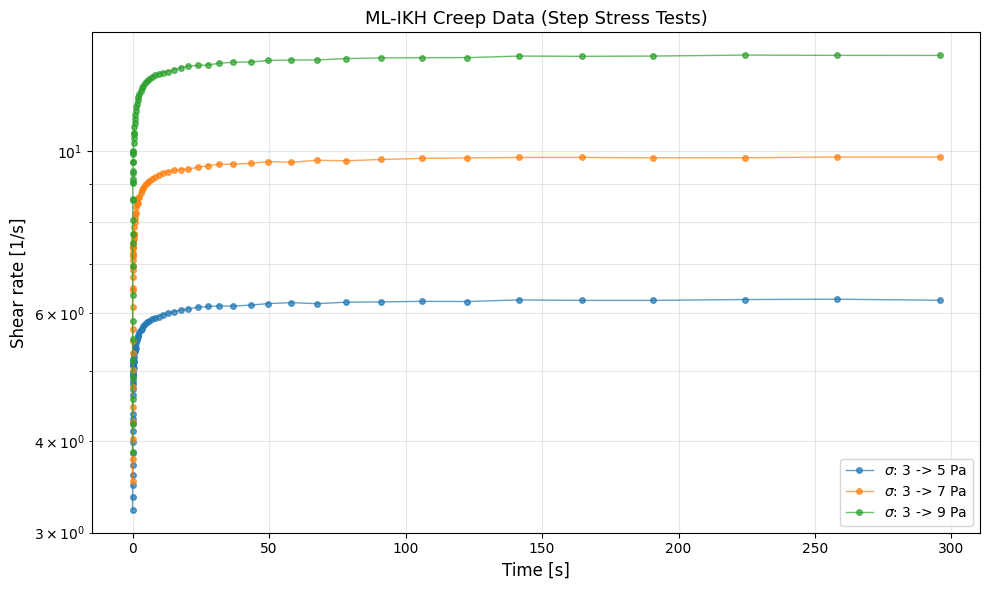

In [4]:
# Plot all creep curves
fig, ax = plt.subplots(figsize=(10, 6))
colors = ["C0", "C1", "C2"]

for i, (key, d) in enumerate(creep_datasets.items()):
    sigma_i, sigma_f = key
    ax.semilogy(d["time"], d["shear_rate"], "o-", color=colors[i], 
                markersize=4, lw=1, alpha=0.7,
                label=f"$\\sigma$: {sigma_i:.0f} -> {sigma_f:.0f} Pa")

ax.set_xlabel("Time [s]", fontsize=12)
ax.set_ylabel("Shear rate [1/s]", fontsize=12)
ax.set_title("ML-IKH Creep Data (Step Stress Tests)", fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 4. NLSQ Fitting

### 4.1 Fit to Single Stress Step

In [5]:
# Select reference dataset (3 -> 7 Pa)
ref_key = (3.0, 7.0)
d = creep_datasets[ref_key]
t_data = d["time"]
gamma_dot_data = d["shear_rate"]
sigma_applied = d["final_stress"]

# Create and fit model
model = MIKH()
param_names = get_mikh_param_names()

print(f"Fitting to creep data: sigma_applied = {sigma_applied} Pa")
t0 = time.time()
# Note: Creep fitting requires special handling as output is shear rate, not stress
# We'll fit to the shear rate response
model.fit(t_data, gamma_dot_data, test_mode="creep", sigma_applied=sigma_applied, method='scipy')
t_nlsq = time.time() - t0

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"\nFitted parameters:")
for name in param_names:
    val = model.parameters.get_value(name)
    print(f"  {name:15s} = {val:.4g}")

Fitting to creep data: sigma_applied = 7.0 Pa


NLSQ fit time: 23.33 s

Fitted parameters:
  G               = 1000
  eta             = 115.5
  C               = 500
  gamma_dyn       = 1
  m               = 1
  sigma_y0        = 10
  delta_sigma_y   = 50
  tau_thix        = 1
  Gamma           = 0.5
  eta_inf         = 0.1
  mu_p            = 0.001


In [6]:
# Predict and compute fit quality
# Note: predict_creep returns strain, we need to compute shear rate
gamma_pred = model.predict(t_data, test_mode="creep", sigma_applied=sigma_applied)

# Compute numerical derivative for shear rate
gamma_dot_pred = np.gradient(np.array(gamma_pred), np.array(t_data))

metrics = compute_fit_quality(gamma_dot_data, gamma_dot_pred)
print(f"\nFit Quality:")
print(f"  R^2:   {metrics['R2']:.6f}")
print(f"  RMSE:  {metrics['RMSE']:.4g} 1/s")


Fit Quality:
  R^2:   -21.174991
  RMSE:  8.134 1/s


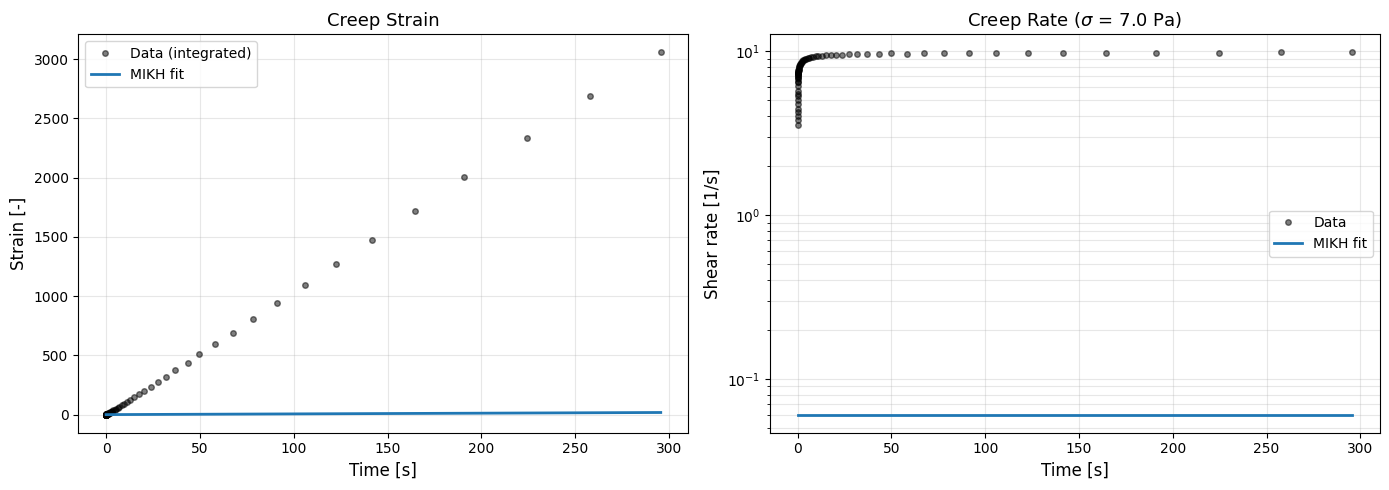

In [7]:
# Plot fit
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Strain vs time
ax1.plot(t_data, np.cumsum(gamma_dot_data * np.gradient(t_data)), "ko", 
         markersize=4, alpha=0.5, label="Data (integrated)")
ax1.plot(t_data, gamma_pred, "-", lw=2, color="C0", label="MIKH fit")
ax1.set_xlabel("Time [s]", fontsize=12)
ax1.set_ylabel("Strain [-]", fontsize=12)
ax1.set_title("Creep Strain", fontsize=13)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Right: Shear rate vs time
ax2.semilogy(t_data, gamma_dot_data, "ko", markersize=4, alpha=0.5, label="Data")
ax2.semilogy(t_data, np.abs(gamma_dot_pred), "-", lw=2, color="C0", label="MIKH fit")
ax2.set_xlabel("Time [s]", fontsize=12)
ax2.set_ylabel("Shear rate [1/s]", fontsize=12)
ax2.set_title(f"Creep Rate ($\\sigma$ = {sigma_applied} Pa)", fontsize=13)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, which="both")

plt.tight_layout()
display(fig)
plt.close(fig)

### 4.2 Multi-Stress Analysis

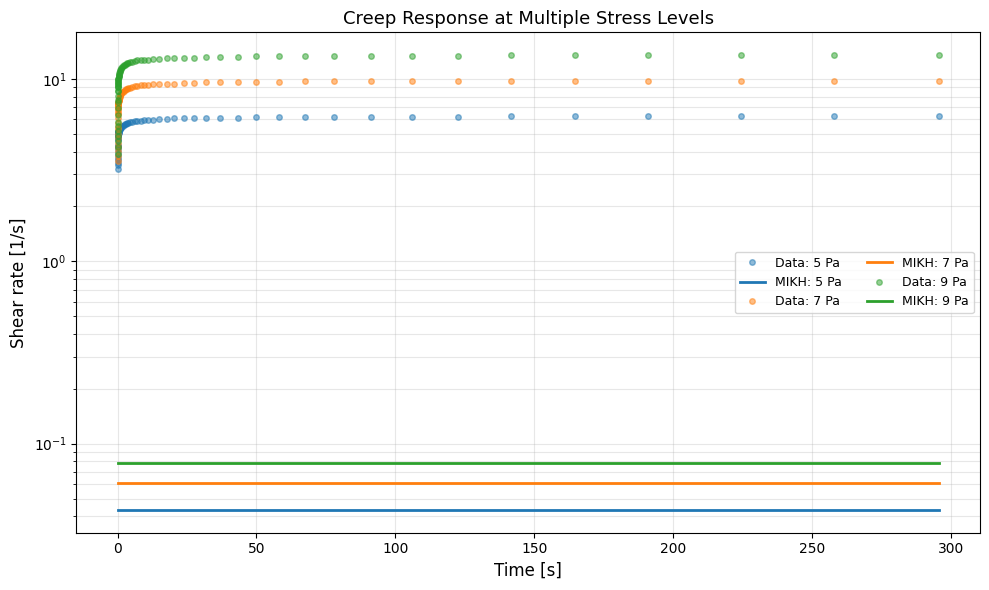

In [8]:
# Predict creep at all stress levels
fig, ax = plt.subplots(figsize=(10, 6))

for i, (key, d) in enumerate(creep_datasets.items()):
    sigma_i, sigma_f = key
    t = d["time"]
    gamma_dot_exp = d["shear_rate"]
    
    # Model prediction
    gamma_pred = model.predict(t, test_mode="creep", sigma_applied=sigma_f)
    gamma_dot_pred = np.gradient(np.array(gamma_pred), np.array(t))
    
    ax.semilogy(t, gamma_dot_exp, "o", color=colors[i], markersize=4, 
                alpha=0.5, label=f"Data: {sigma_f:.0f} Pa")
    ax.semilogy(t, np.abs(gamma_dot_pred), "-", color=colors[i], lw=2,
                label=f"MIKH: {sigma_f:.0f} Pa")

ax.set_xlabel("Time [s]", fontsize=12)
ax.set_ylabel("Shear rate [1/s]", fontsize=12)
ax.set_title("Creep Response at Multiple Stress Levels", fontsize=13)
ax.legend(fontsize=9, ncol=2)
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Bayesian Inference with NUTS

In [9]:
# Clear JAX compilation caches before Bayesian inference to reduce peak memory
import gc
gc.collect()
try:
    jax.clear_caches()
except Exception:
    pass

# Bayesian inference
initial_values = {name: model.parameters.get_value(name) for name in param_names}

# FAST_MODE: reduced samples for CI; set FAST_MODE=0 for production
FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"

if FAST_MODE:
    NUM_WARMUP = 50
    NUM_SAMPLES = 100
    NUM_CHAINS = 1
else:
    NUM_WARMUP = 200
    NUM_SAMPLES = 500
    NUM_CHAINS = 1

print(f"Running NUTS: {NUM_WARMUP} warmup + {NUM_SAMPLES} samples x {NUM_CHAINS} chain(s)")
t0 = time.time()
result = model.fit_bayesian(
    t_data,
    gamma_dot_data,
    test_mode="creep",
    sigma_applied=sigma_applied,
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    initial_values=initial_values,
    seed=42,
)
t_bayes = time.time() - t0
print(f"\nBayesian inference time: {t_bayes:.1f} s")

Running NUTS: 50 warmup + 100 samples x 1 chain(s)


  0%|          | 0/150 [00:00<?, ?it/s]

warmup:   1%|          | 1/150 [00:03<07:30,  3.02s/it, 1 steps of size 1.95e+00. acc. prob=0.00]

warmup:  16%|█▌        | 24/150 [00:03<00:11, 10.58it/s, 127 steps of size 9.89e-02. acc. prob=0.83]

warmup:  23%|██▎       | 35/150 [00:03<00:07, 14.81it/s, 63 steps of size 6.97e-02. acc. prob=0.85] 

warmup:  29%|██▊       | 43/150 [00:03<00:05, 18.15it/s, 255 steps of size 3.97e-02. acc. prob=0.85]

sample:  38%|███▊      | 57/150 [00:03<00:03, 28.53it/s, 63 steps of size 7.79e-02. acc. prob=0.85] 

sample:  52%|█████▏    | 78/150 [00:03<00:01, 48.32it/s, 15 steps of size 7.79e-02. acc. prob=0.88]

sample:  66%|██████▌   | 99/150 [00:03<00:00, 70.12it/s, 7 steps of size 7.79e-02. acc. prob=0.88] 

sample:  79%|███████▊  | 118/150 [00:04<00:00, 88.73it/s, 31 steps of size 7.79e-02. acc. prob=0.89]

sample:  92%|█████████▏| 138/150 [00:04<00:00, 108.68it/s, 47 steps of size 7.79e-02. acc. prob=0.90]

sample: 100%|██████████| 150/150 [00:04<00:00, 35.51it/s, 31 steps of size 7.79e-02. acc. prob=0.89] 


Bayesian inference time: 9.6 s


In [10]:
# Convergence diagnostics
all_pass = print_convergence_summary(result, param_names)

Convergence Diagnostics
      Parameter     R-hat       ESS    Status
-------------------------------------------------------
              G    0.9911       152      PASS
            eta    1.0001        87     CHECK
              C    0.9914       118      PASS
      gamma_dyn    0.9906       127      PASS
              m    0.9994        24     CHECK
       sigma_y0    0.9900       164      PASS
  delta_sigma_y    1.0117       207      PASS
       tau_thix    0.9953       118      PASS
          Gamma    0.9900       140      PASS
        eta_inf    0.9910       215      PASS
           mu_p    1.0088       105      PASS

Divergences: 0

CHECK REQUIRED: Increase num_warmup/num_samples or check warm-start


/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/arviz/plots/backends/matplotlib/pairplot.py:223: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


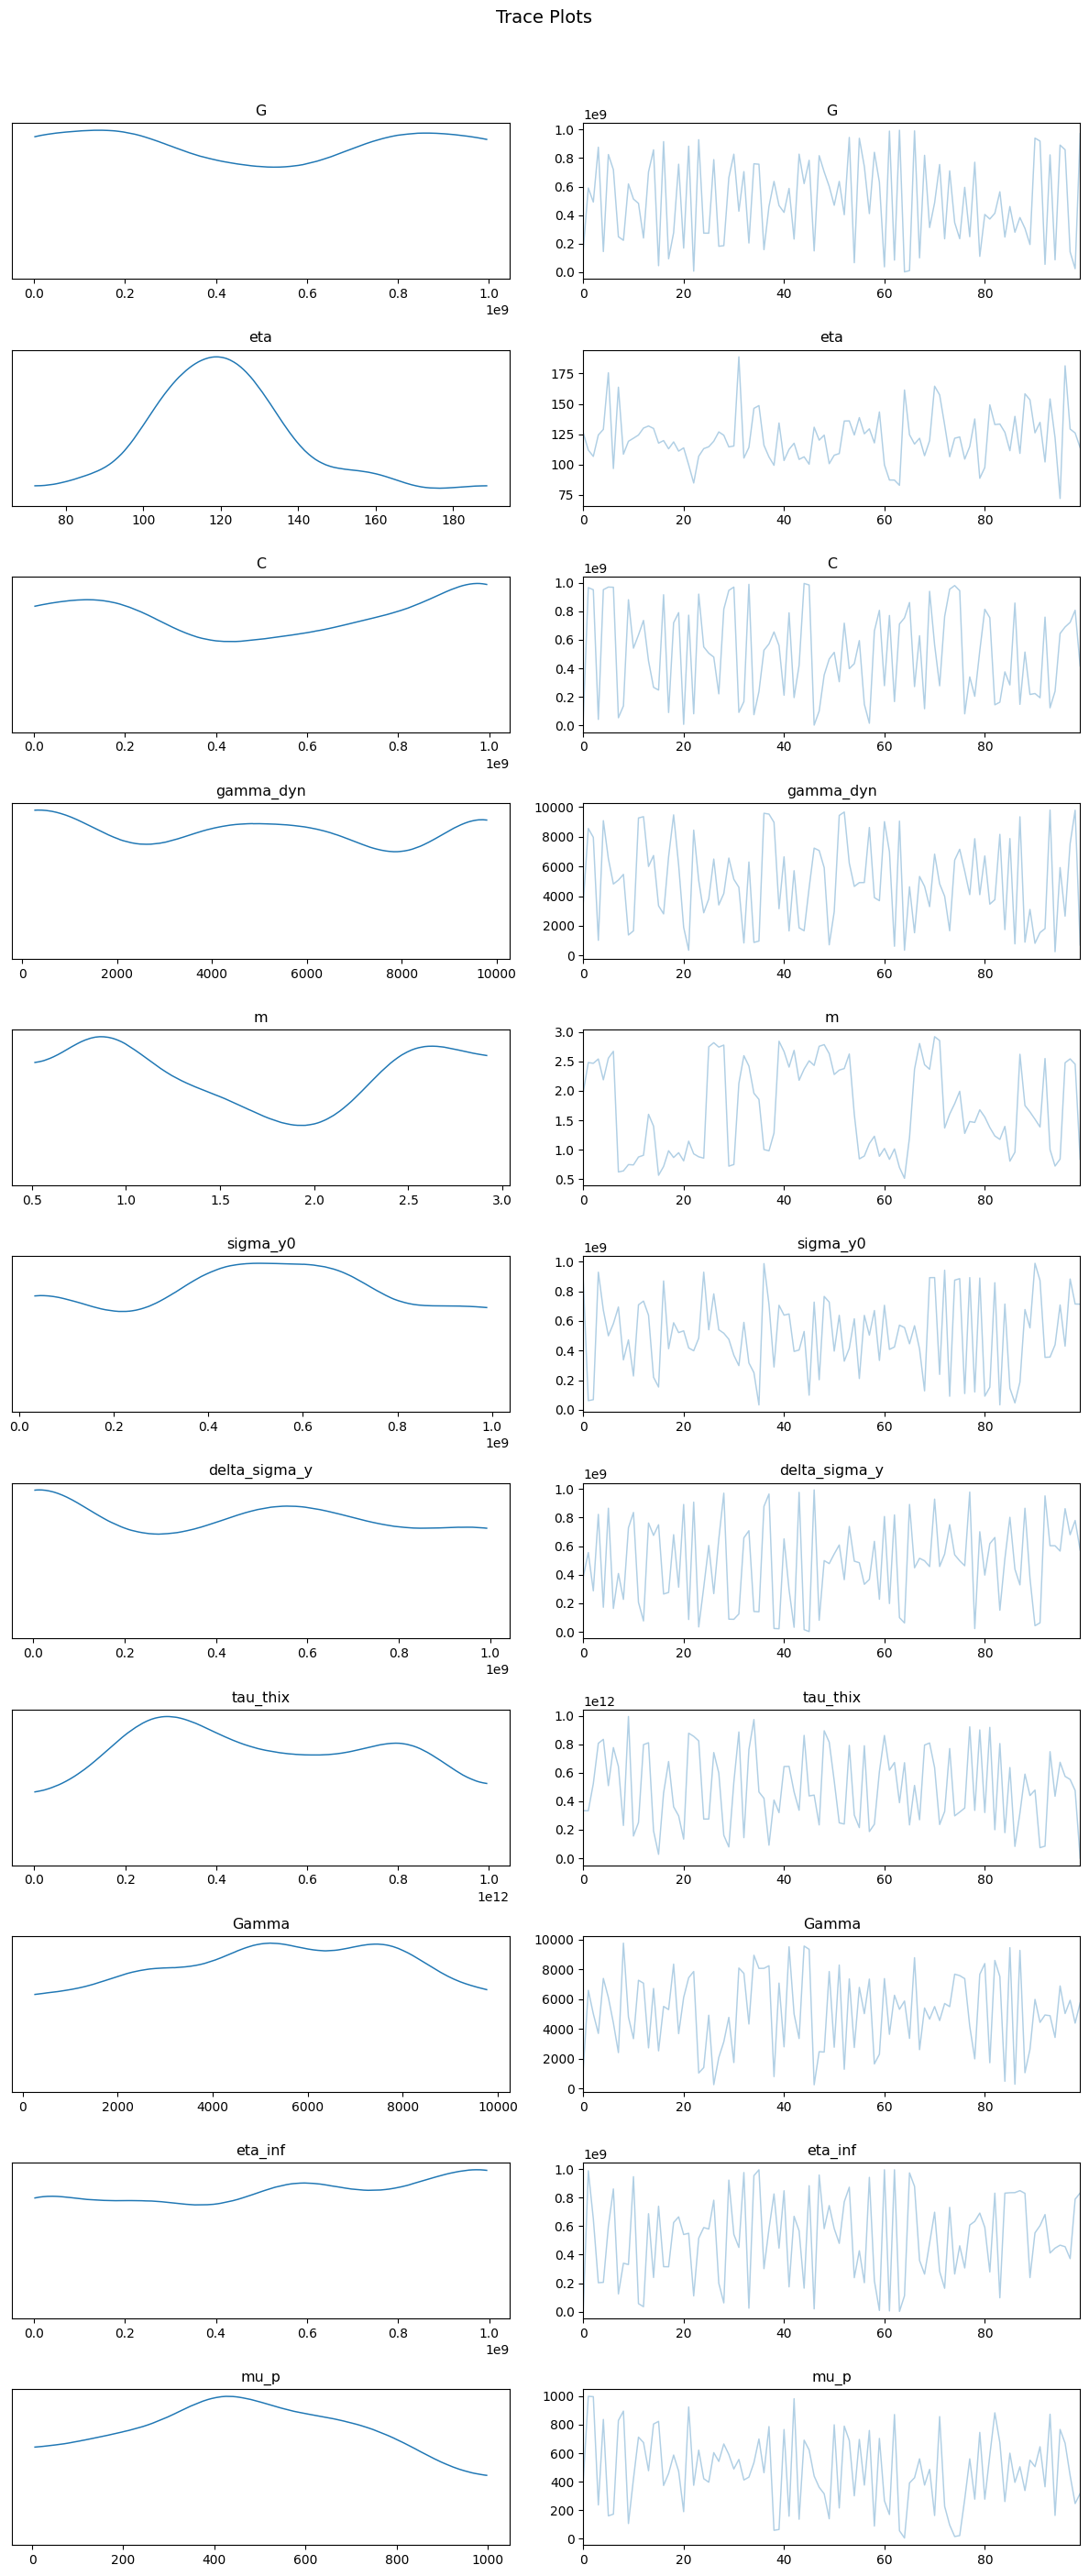

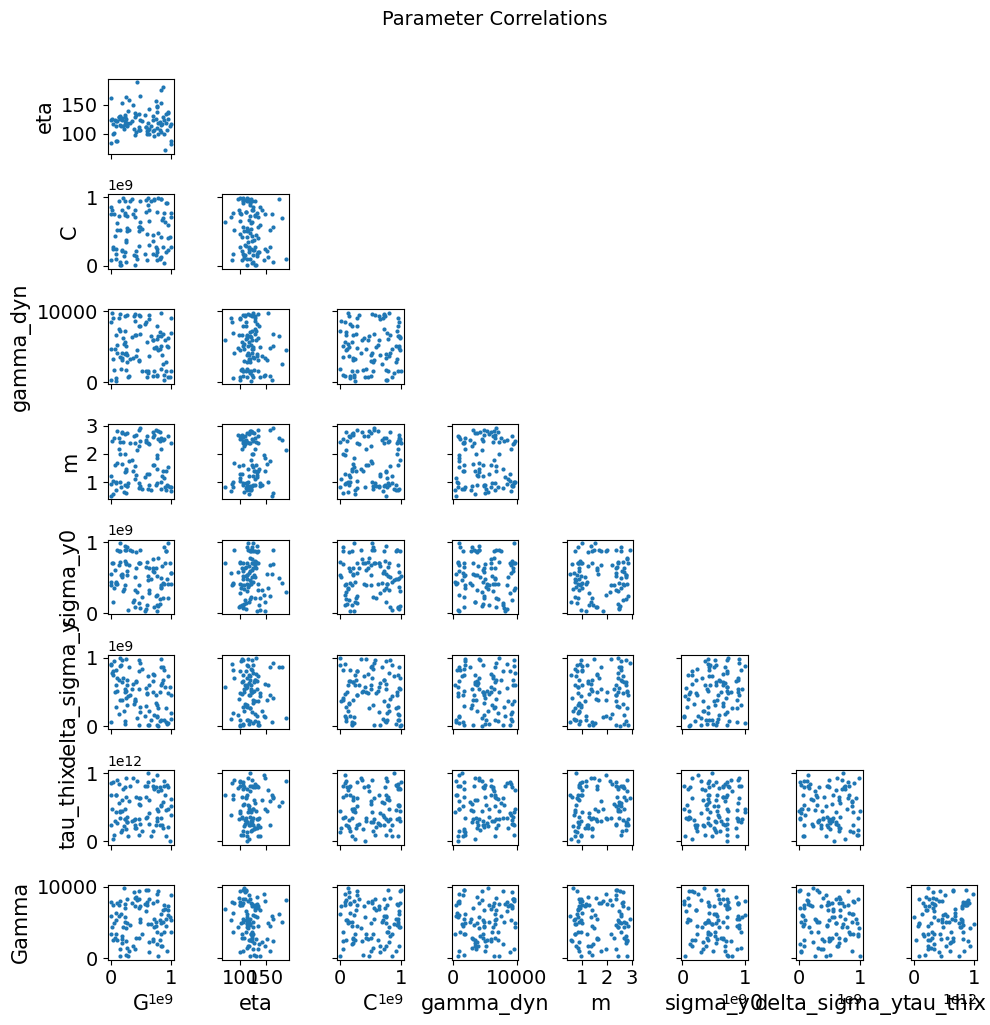

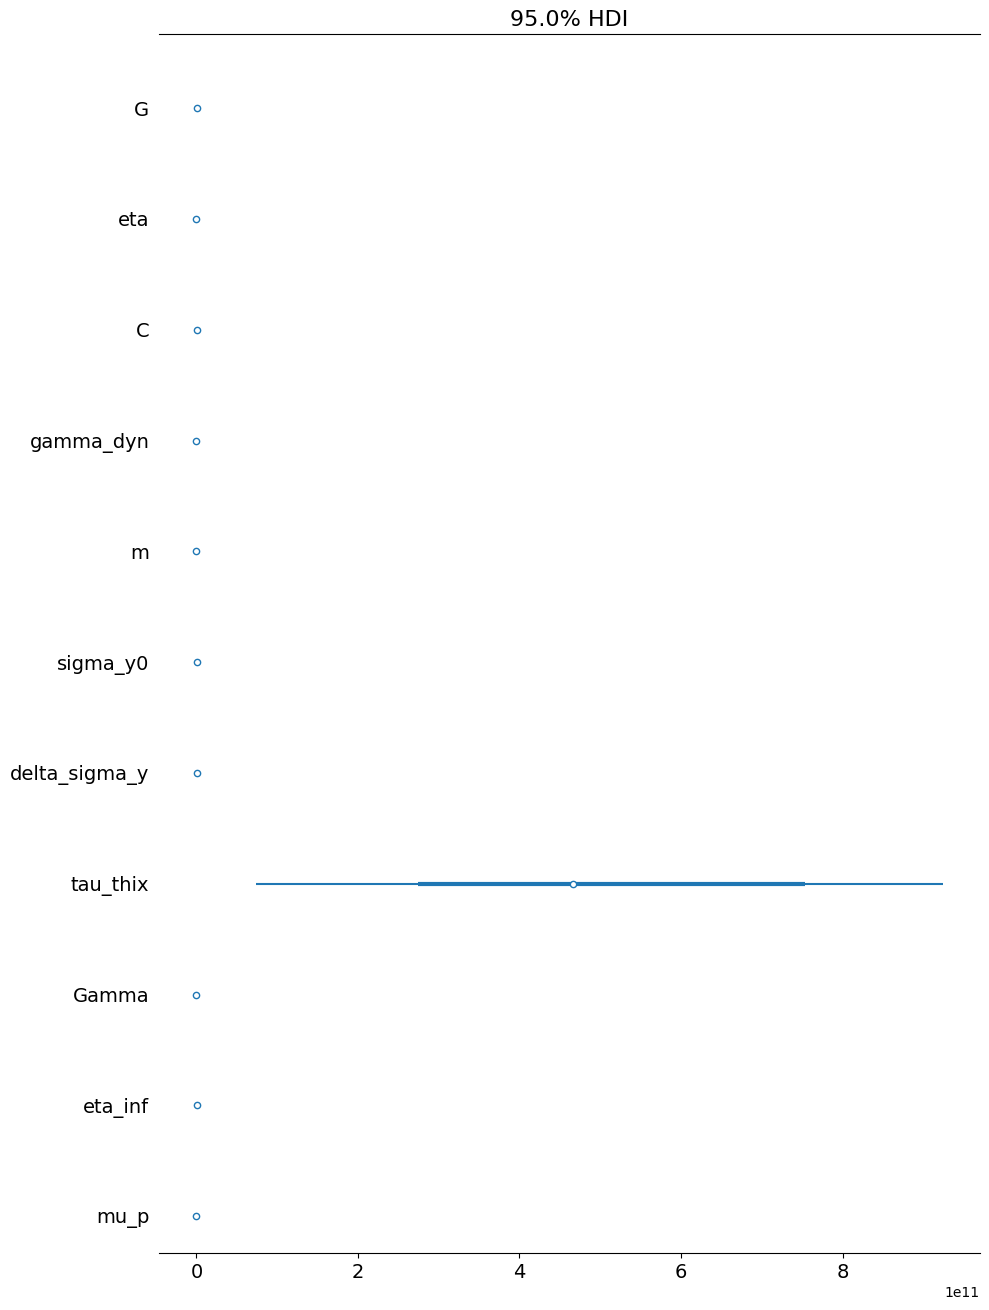

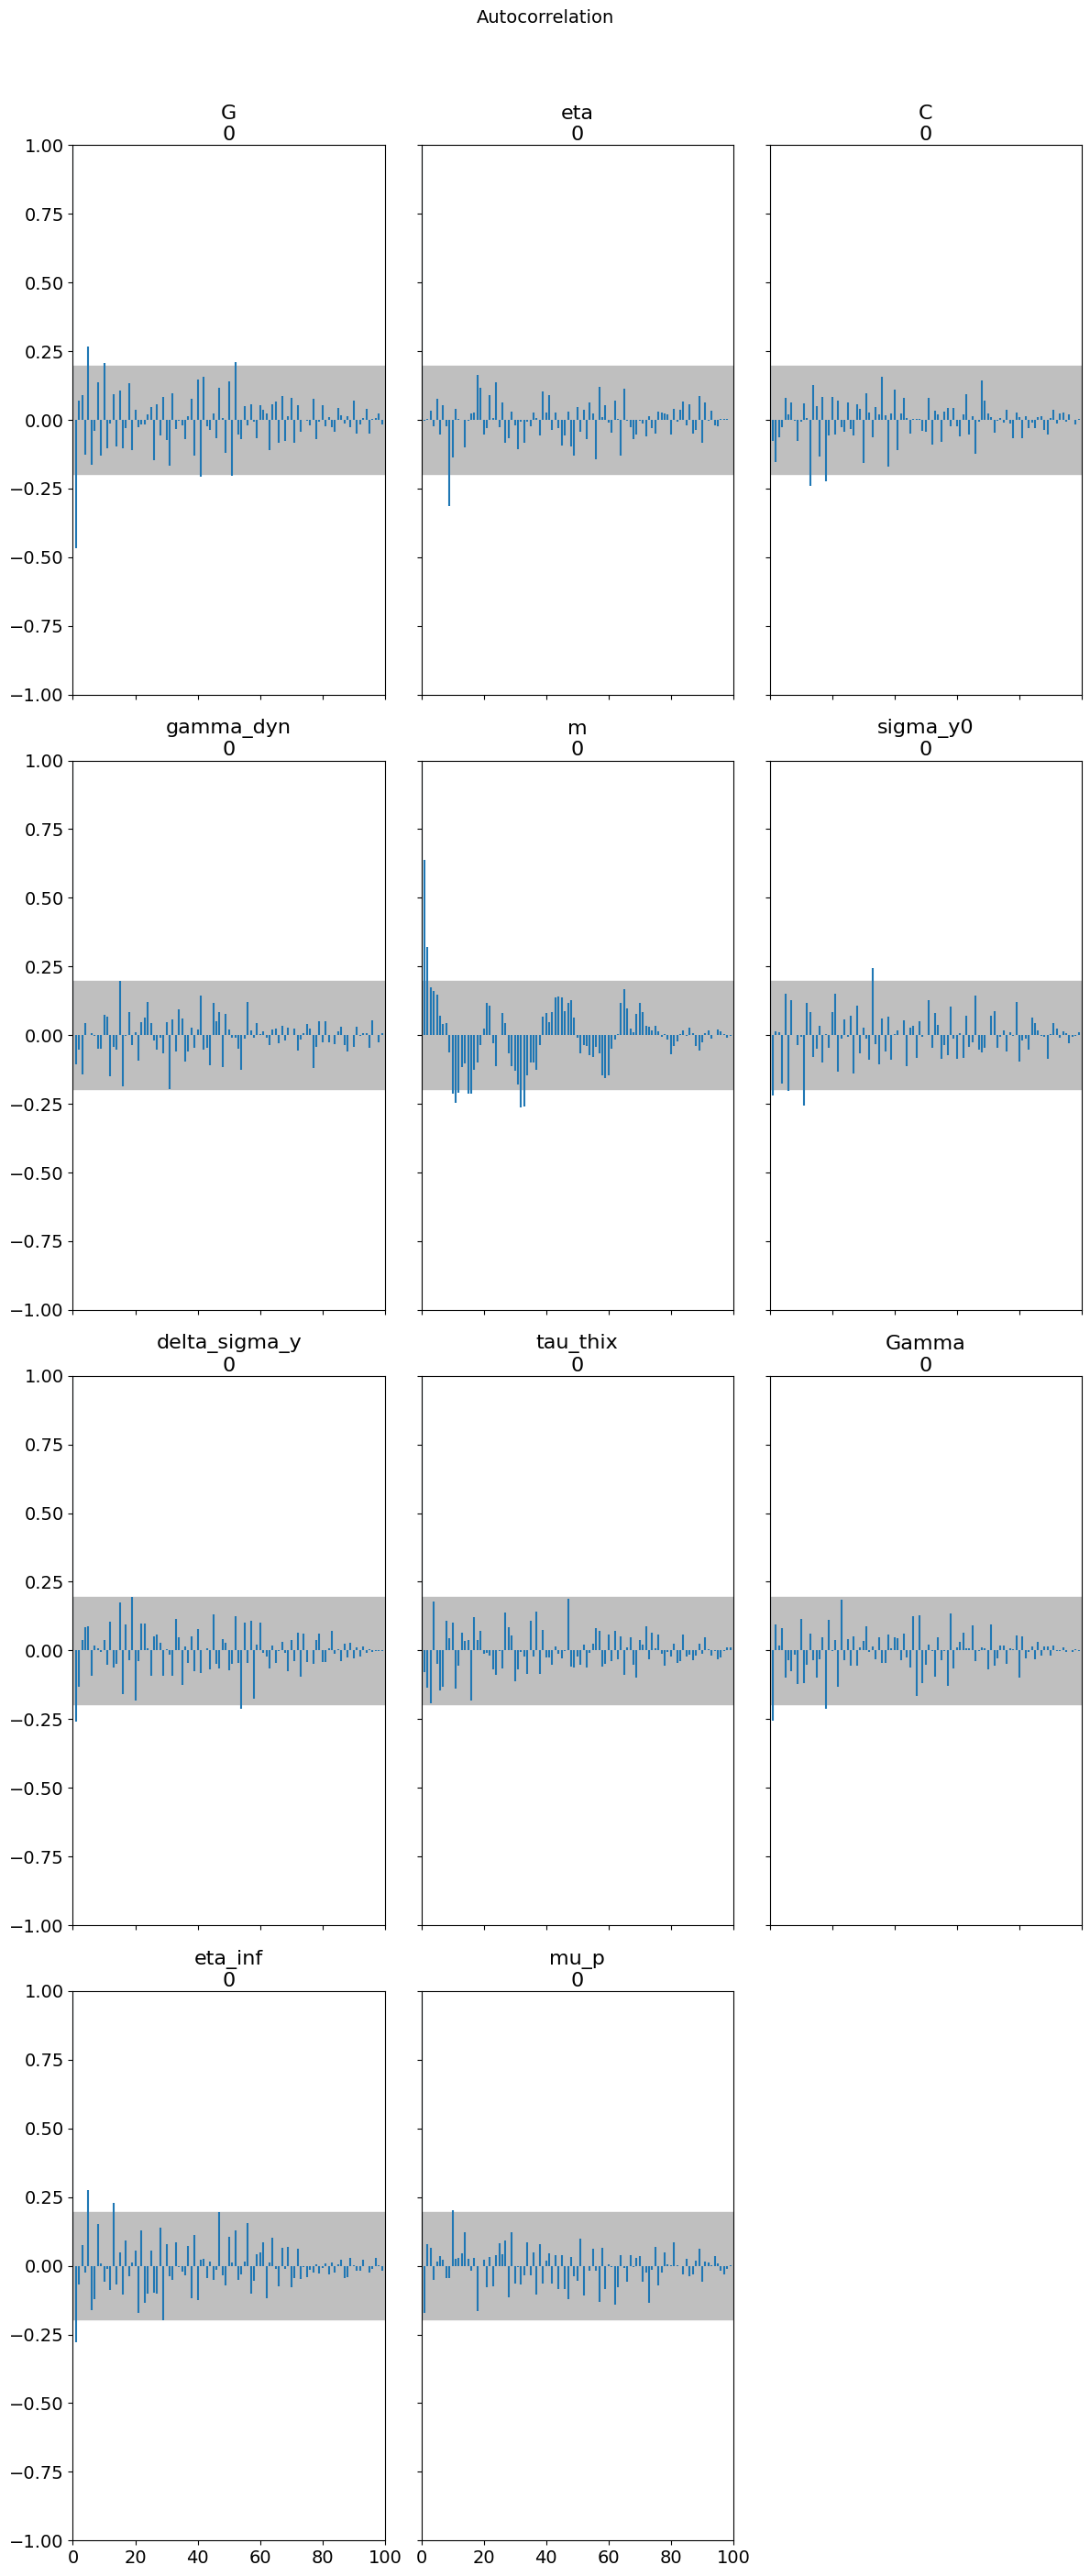

In [11]:
# ArviZ diagnostic plots (trace, pair, forest, energy, autocorrelation, rank)
display_arviz_diagnostics(result, param_names, fast_mode=FAST_MODE)

In [12]:
# Parameter comparison
posterior = result.posterior_samples
print_parameter_comparison(model, posterior, param_names)


Parameter Comparison: NLSQ vs Bayesian
      Parameter          NLSQ        Median                          95% CI
---------------------------------------------------------------------------
              G          1000     4.756e+08  [1.659e+07, 9.814e+08]
            eta         115.5         119.6  [85.83, 170.3]
              C           500     5.184e+08  [2.726e+07, 9.828e+08]
      gamma_dyn             1          4871  [489.1, 9627]
              m             1         1.577  [0.6318, 2.829]
       sigma_y0            10     5.252e+08  [5.345e+07, 9.366e+08]
  delta_sigma_y            50     4.974e+08  [2.289e+07, 9.732e+08]
       tau_thix             1      4.66e+11  [7.663e+10, 9.222e+11]
          Gamma           0.5          5173  [378.2, 9503]
        eta_inf           0.1     5.512e+08  [1.323e+07, 9.917e+08]
           mu_p         0.001         468.2  [38.4, 954.4]


## 6. Physical Interpretation

### Viscosity Bifurcation

The creep response reveals the **viscosity bifurcation** characteristic of thixotropic yield-stress fluids:

- **Below yield**: Material reaches a bounded creep state, effectively infinite viscosity
- **Above yield**: Material flows with finite viscosity that depends on structure

### Delayed Yielding Mechanism

1. Apply stress slightly above yield
2. Initial slow creep at high viscosity
3. Structure gradually breaks down
4. Yield stress decreases
5. When $\sigma_y(\lambda) < \sigma_{app}$: rapid acceleration
6. Approach steady-state flow

## 7. Save Results

In [13]:
# Save results
save_ikh_results(model, result, "mikh", "creep", param_names)

Results saved to /Users/b80985/Projects/rheojax/examples/ikh/../utils/../outputs/ikh/mikh/creep/
  nlsq_params_creep.json: 11 parameters
  posterior_creep.json: 100 draws


## Key Takeaways

1. **Creep tests** reveal the yield behavior and thixotropic dynamics of MIKH materials

2. **Delayed yielding** occurs when applied stress is near the yield stress

3. **Viscosity bifurcation**: Flow vs no-flow depends on stress relative to evolving yield stress

4. **Structure evolution** during creep: breakdown under flow, rebuilding at rest

5. **Perzyna regularization** ($\mu_p$) controls the rate-dependence of plastic flow

### Next Steps

- **NB05**: SAOS (synthetic from NB01 calibration)
- **NB06**: LAOS (real PNAS data)

In [14]:
# Cleanup: release JAX caches and Python garbage for sequential notebook runs
import gc
try:
    jax.clear_caches()
except Exception:
    pass
gc.collect()
print("Notebook complete. Memory cleaned up.")


Notebook complete. Memory cleaned up.
